In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde as kde
# from scipy.stats import norm, uniform, multivariate_normal as multinorm, norm
# from tqdm import tqdm
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline
np.set_printoptions(edgeitems=10, linewidth=120, suppress=True, precision=8)

from pertussis import *
logger.setLevel(logging.INFO)

2017-10-30-22-07-57.log


# Make Simulation
## Load

In [22]:
# save_mcmc(mcmc, path='./chains/0516-ppt.pkl')

In [3]:
#load simulation
simulation = load_mcmc('./simulations/')
mcmc = simulation['mcmc']
print(simulation['name'])
print(mcmc['name'])

ppt_0515
mcmc_0


In [37]:
# Load MCMC
# mcmc = load_mcmc('./chains/0428-9k-singular.pklmcmc_0.pkl')
# mcmc = load_mcmc('./chains/0531-40k.pklmcmc_0.pkl')
mcmc = load_mcmc('./chains/1030mcmc_2.pkl')
print (mcmc['name'],': ',len(mcmc['chain']))
names = mcmc['names']

# Distributions
dists = mcmc['dists']

# Times
r_start = mcmc['start']
r_end = mcmc['end']
step = 1 / N

# Data
data_M, months = mcmc['datax'], mcmc['datay']
# data2, data2n, years = cases_yearly()
state_0 = mcmc['state_0']

mcmc_2 :  13405


## Computed Parameters

In [38]:
# Pick Chains for Simulation
l = len(mcmc['guesses'])
mcmc['state_z_subset'] = mcmc['state_z'][-l//4::3,:] 
mcmc['chain_subset'] = mcmc['guesses'][-l//4::3,:]
cut = mcmc['state_z_subset'].sum(axis=1) > 0
mcmc['chain_subset'] = mcmc['chain_subset'][cut,:]
mcmc['state_z_subset'] = mcmc['state_z_subset'][cut,:]

In [36]:
#Save simulation
save_mcmc(simulation, './simulations/1030-simulation-0.pkl')

## Create Policies

In [39]:
# Create Policies
default = init_policy('default')
everybody = init_policy('everybody', vax_ages=a_u)
no_one = init_policy('no_one', vax_ages=[])

# possible_ages = [5,6,7,8,9,10,11,12,13,15,18]

policies = [default, everybody, no_one]

# Remove
# only_age = [5,6,7,10,13]
only_age = [5,7,13]
for age in only_age:
    p_name = 'REMOVE_{:02d}'.format(age)
    tmp_ages = (2 / 12, 4 / 12, 6 / 12, 1, age)
    tmp_policy = init_policy(p_name, vax_ages=tmp_ages)
    policies.append(tmp_policy)
    
# Shift
possible_ages = [5,6,7,10,13,18]
# possible_ages = [5,7,13,18]
for i in range(len(possible_ages)):
    for j in range(i):
        agej, agei = possible_ages[j],possible_ages[i]
        p_name = 'SHIFT_{:02d}_{:02d}'.format(agej,agei)
        tmp_ages = (2 / 12, 4 / 12, 6 / 12, 1, agej, agei)
        tmp_policy = init_policy(p_name, vax_ages=tmp_ages)
        policies.append(tmp_policy)

# Add
additional_ages = [5,6,8,10,15]
# additional_ages = [5]
for age in additional_ages:
    p_name = 'ADD_{:02d}'.format(age)
    tmp_ages = (2 / 12, 4 / 12, 6 / 12, 1, 7, 13, age)
    tmp_policy = init_policy(p_name, vax_ages=tmp_ages)
    policies.append(tmp_policy)
# Create the simulation


dynamic_add_ages = [5,6,10]
for age in dynamic_add_ages:
    for mod_year in range(4):
        p_name = 'DYNAMIC7_{:02d}_{:1d}'.format(age, mod_year)
        tmp_ages = (2 / 12, 4 / 12, 6 / 12, 1, 7, 13)
        tmp_policy = init_policy(p_name, vax_ages=tmp_ages, mod_year=mod_year, dynamic=age)
        policies.append(tmp_policy)
        
# Dynamic
dynamic_add_ages = [6,7,10,15]
for age in dynamic_add_ages:
    for mod_year in range(4):
        p_name = 'DYNAMIC5_{:02d}_{:1d}'.format(age, mod_year)
        tmp_ages = (2 / 12, 4 / 12, 6 / 12, 1, 5, 13)
        tmp_policy = init_policy(p_name, vax_ages=tmp_ages, mod_year=mod_year, dynamic=age)
        policies.append(tmp_policy)


        
print (len(policies))
simulation = init_simulation("with_dynamic_0606", mcmc, policies)
simulation.keys()

54


dict_keys(['mcmc', 'start', 'end', 'name', 'pregnant_coverage', 'data_sick', 'subset_pick', 'policies', 'p', 'data_hospital', 'dist'])

# SIMULATE

In [40]:
tst = mcmc['initial_guess'].copy()
print (tst)
tst[mcmc['active_params']] = mcmc['chain_subset'][-80,:]
print (tst)
print (mcmc['chain_subset'][-80,:])

[  3.9805   2.8645  50.       0.001    0.0003   0.0001]
[  3.9805   2.9687  50.       0.0012   0.0003   0.0001]
[ 2.9687  0.0012  0.0003  0.0001]


In [41]:
simulate_future(simulation, 40)

L 1118



## Create pairwise

In [42]:
policies = simulation['policies']
default = policies[0]
metric_names = ['sick','hospital','vaccines']
age_names = ['0-1','1-21','21+']
#Make differences from default
for policy in policies:
    policy['sick_diff'] = np.array(policy['sick']) - np.array(default['sick'])
    policy['hospital_diff'] = np.array(policy['hospital']) - np.array(default['hospital'])
    policy['vaccines_diff'] = np.array(policy['vaccines']) - np.array(default['vaccines'])
    policy['ratio'] = (np.array(policy['sick'])).sum(axis=1) / (np.array(policy['vaccines'])).sum(axis=1)
    # IMPORTANT: Default has to be first!!!!!
#     policy['ratio_diff'] = policy['ratio'] - default['ratio']
    policy['ratio_diff'] = np.array(policy['sick_diff']).sum(axis=1) / np.array(policy['vaccines']).sum(axis=1)

# Charts
## Default Policy Stats
### Histogram

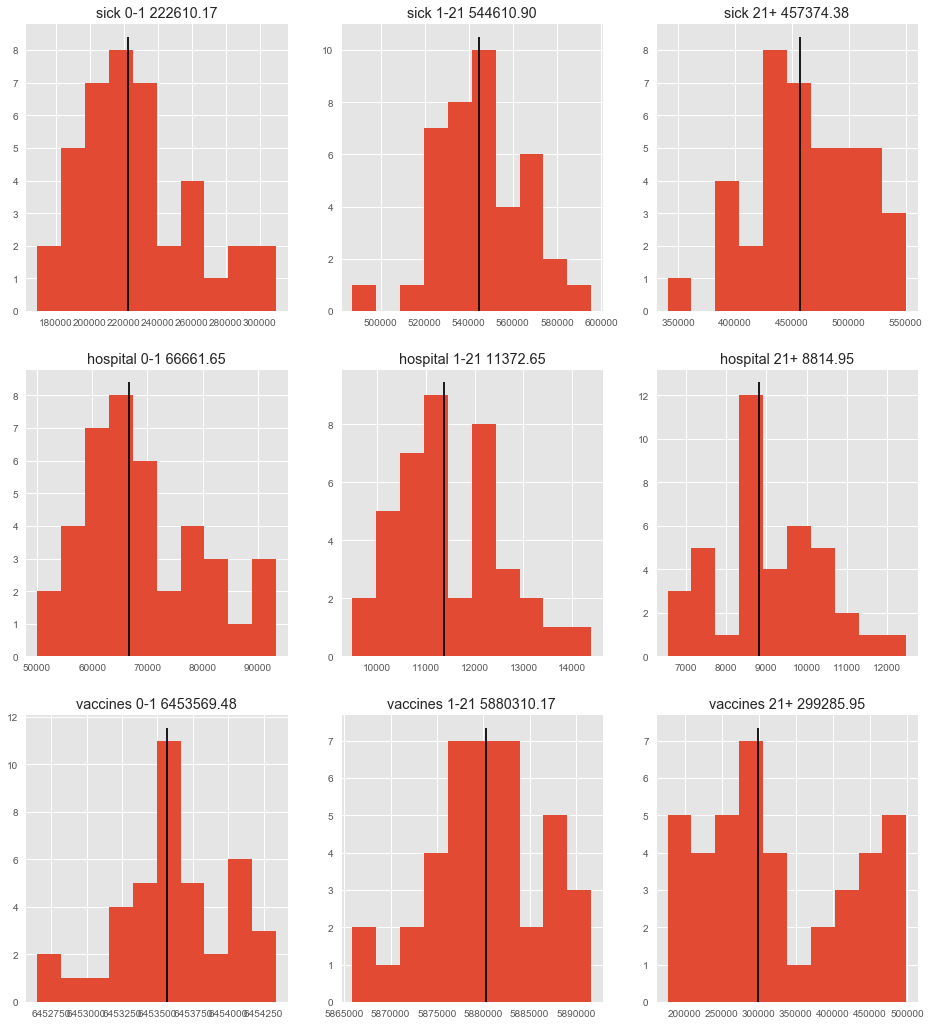

In [43]:
fig, axs = plt.subplots(3,3,figsize=(16,18))
policy = default
for i, metric in enumerate(metric_names): # i - i is ax row: result type
#     print me`
    for age in range(3): # j is age
        arr = np.array(policy[metric])[:,age]
        ax = axs[i,age]
        ax.hist(arr)
        m = ax.get_ylim()[1]
        ax.vlines(np.median(arr), 0, m)
        ax.set_title('{} {} {:.2f}'.format(metric,age_names[age], np.median(arr)))


### Correlations

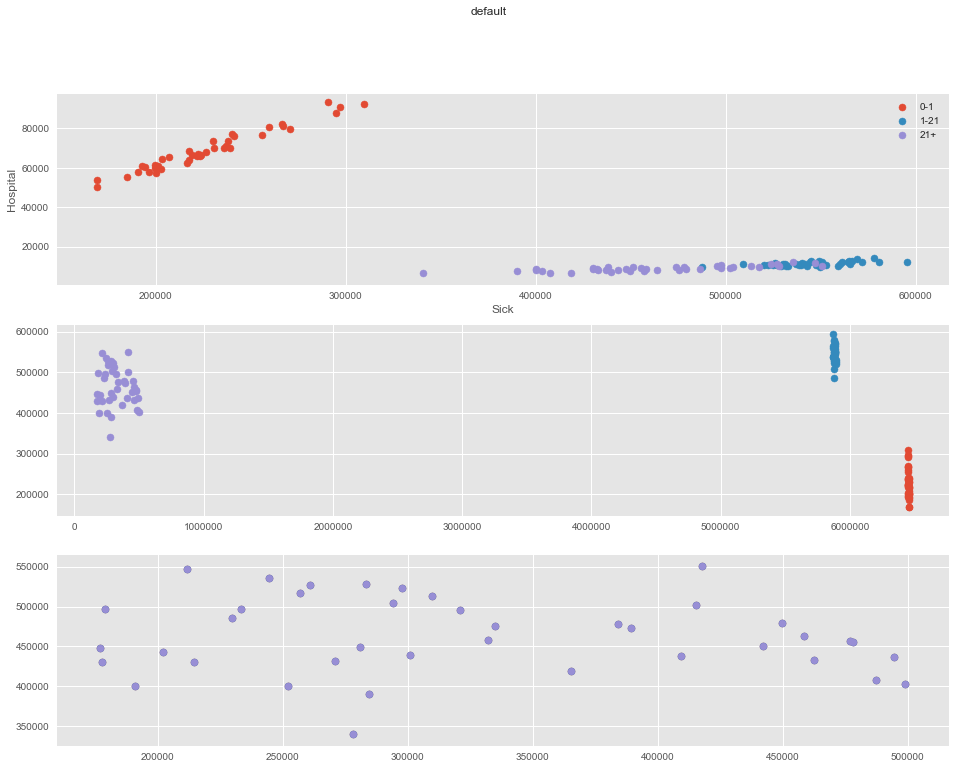

In [44]:
fig, ax = plt.subplots(3,figsize=(16,12))
policy = policies[0]
for i in range(3):
    ax[0].scatter(np.array(policy['sick'])[:,i], np.array(policy['hospital'])[:,i], label=age_names[i])
    ax[1].scatter(np.array(policy['vaccines'])[:,i], np.array(policy['sick'])[:,i], label=age_names[i])
    ax[2].scatter(np.array(policy['vaccines'])[:,2], np.array(policy['sick'])[:,2], label=age_names[i])
ax[0].set_xlabel('Sick')
ax[0].set_ylabel('Hospital')
fig.suptitle(policy['name'])                           
ax[0].legend()
plt.show()

In [45]:
fontdict={'fontsize':12}

In [46]:
metric_diffs = ["{}_diff".format(m) for m in metric_names]# + ['ratio_diff']
compare_policies = policies[:1] + policies[3:]
policy_names = [policy['name'] for policy in compare_policies]
bp = [np.array([ix[metric].sum(axis=1) for ix in compare_policies]).T for metric in metric_diffs]
bp += [np.array([ix['ratio_diff'] for ix in compare_policies]).T]
bp1y = [np.array([ix[metric][0,:] for ix in compare_policies]).T for metric in metric_diffs]

# DataFrame
df_sick = pd.DataFrame(data=bp[0], columns=policy_names)
df_hospital = pd.DataFrame(data=bp[1], columns=policy_names)
df_ratio = pd.DataFrame(data=bp[3], columns=policy_names)

In [47]:
# colors
colors = {}
for p in policies:
    name = p['name']
    if 'REMOVE' in name:
        colors[name] = 'C0'
    elif 'SHIFT' in name:
        colors[name] = 'C1'
    elif 'ADD' in name:
        colors[name] = 'C4'
    elif 'DYNAMIC7' in name:
        colors[name] = 'C5'
    elif 'DYNAMIC5' in name:
        colors[name] = 'C6'
    else:
        colors[name] = 'C3'

## Comparison

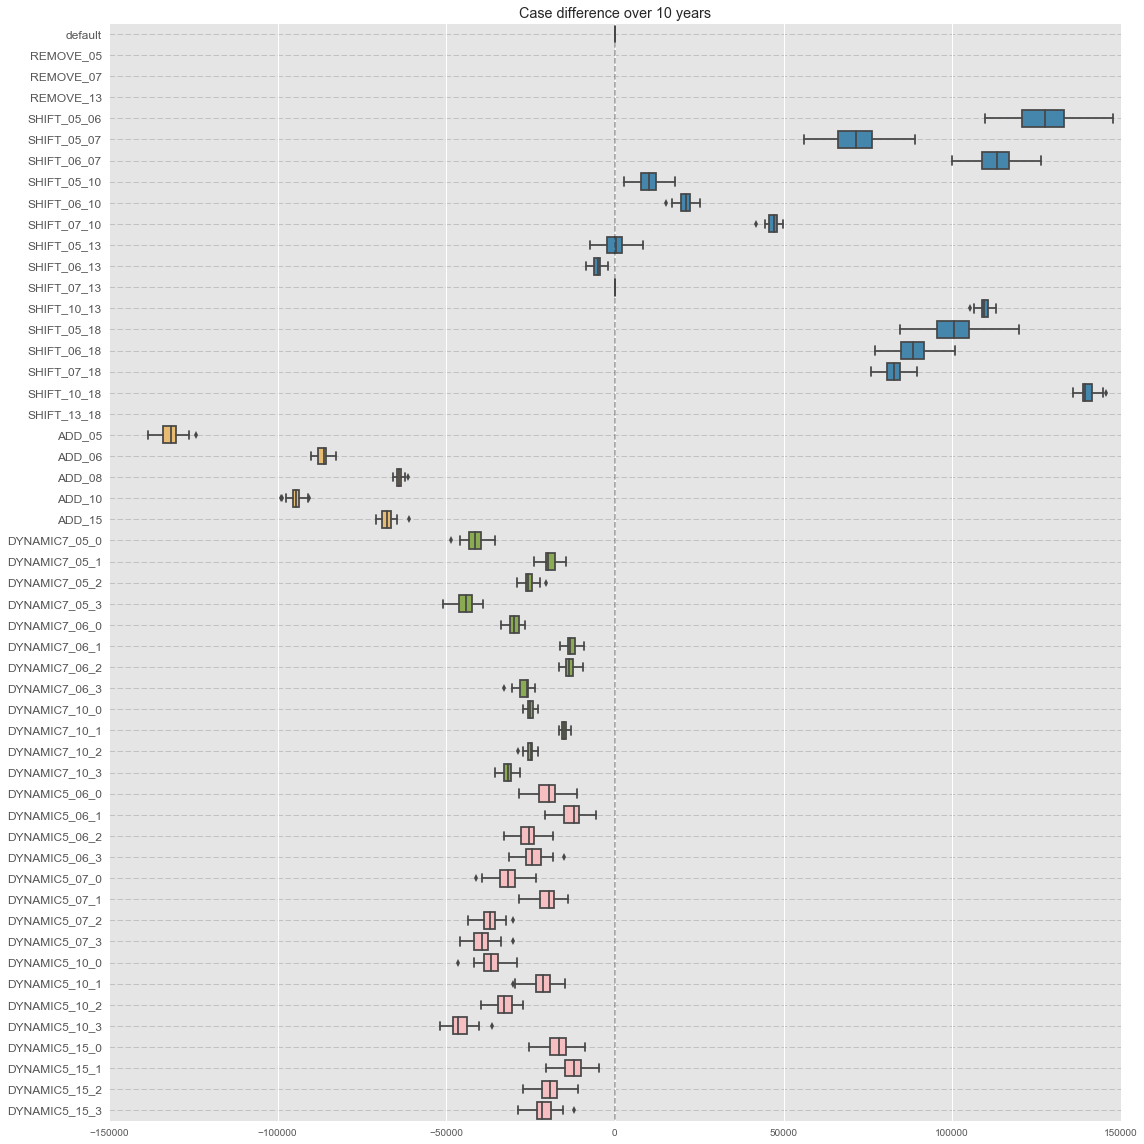

In [48]:
fig, axs = plt.subplots(1,figsize=(16,16))
# x = np.array([ix['sick_diff'].sum(axis=1) for ix in compare_policies]).T
# x.shape
ax=axs#[0]
sns.boxplot(data=df_sick, ax=ax, orient="h", palette=colors)
ax.set_yticklabels(policy_names, fontdict=fontdict)#, rotation='vertical')
ax.set_title("Case difference over 10 years")
ax.vlines(0,0,len(compare_policies),linestyles='--',alpha=0.3)
lims = -150000, 150000
ax.hlines(np.arange(len(compare_policies)),*lims,linestyles='--',alpha=0.3, zorder=-5, lw=0.5)
ax.set_xlim(*lims)

# ax=axs[1]
# sns.boxplot(data=bp1y[0], ax=ax, orient="h")
# ax.set_yticklabels([])
# ax.set_title("Sick babies (0-1) difference over 10 years")
# ax.vlines(0,0,len(compare_policies),linestyles='--',alpha=0.3)
plt.tight_layout()
plt.show()

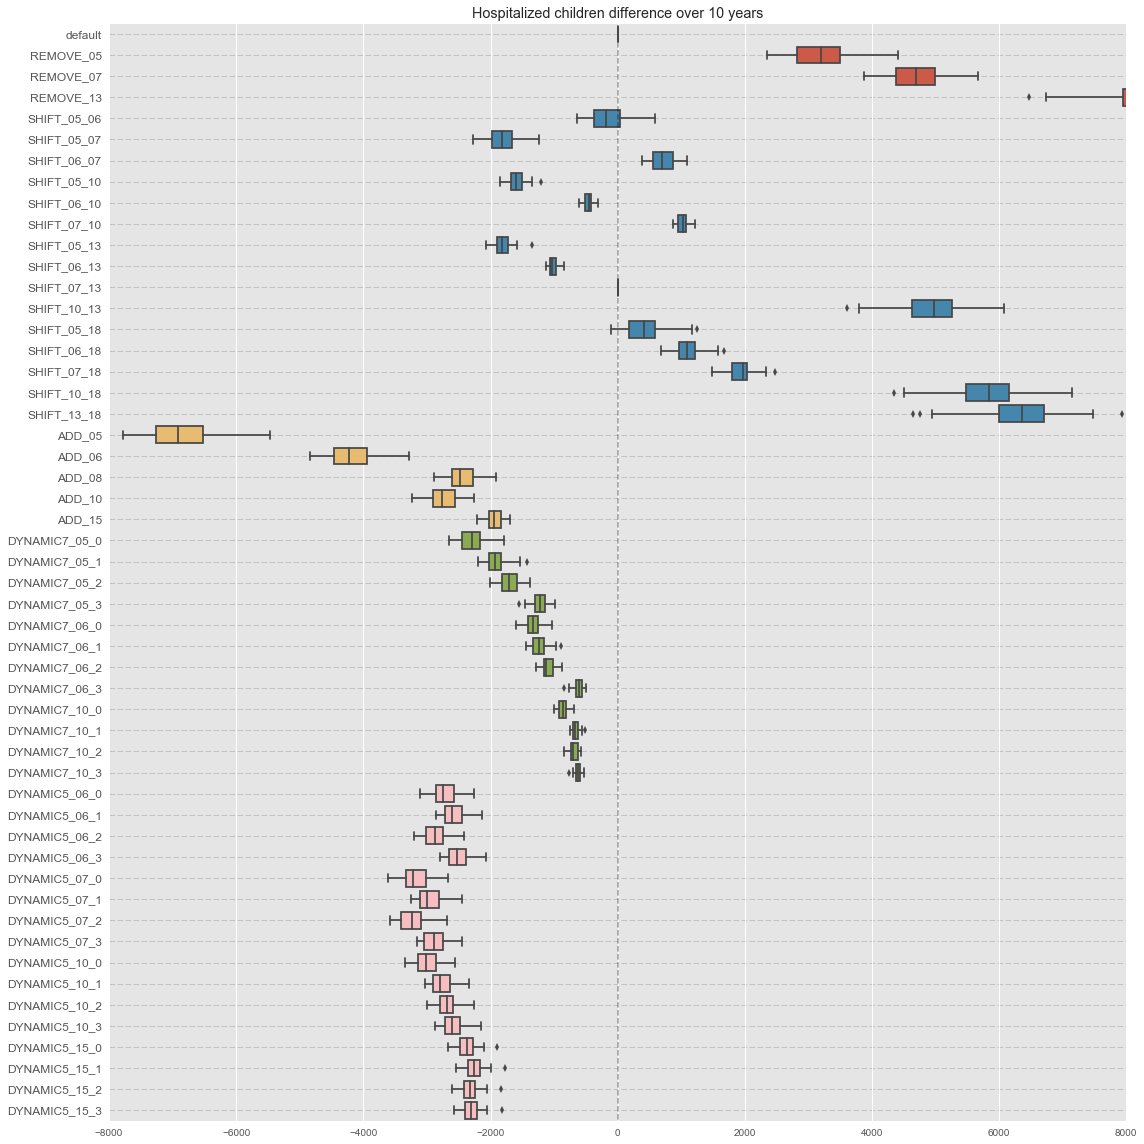

In [21]:
fig, axs = plt.subplots(1,figsize=(16,16))
ax=axs#[0]
sns.boxplot(data=df_hospital, ax=ax, orient="h",palette=colors)
ax.set_yticklabels(policy_names, fontdict=fontdict)#, rotation='vertical')
ax.set_title("Hospitalized children difference over 10 years")
ax.vlines(0,0,len(compare_policies),linestyles='--',alpha=0.3)
lims = -8000, 8000
ax.hlines(np.arange(len(compare_policies)),*lims,linestyles='--',alpha=0.3, zorder=-5, lw=0.5)
ax.set_xlim(*lims)

# ax=axs[1]
# sns.boxplot(data=bp1y[0]/bp1y[2], ax=ax, orient="h")
# ax.set_yticklabels([])
# ax.set_title("Sick babies (0-1) difference over 10 years")
# ax.vlines(0,0,len(compare_policies),linestyles='--',alpha=0.3)
plt.tight_layout()
plt.show()

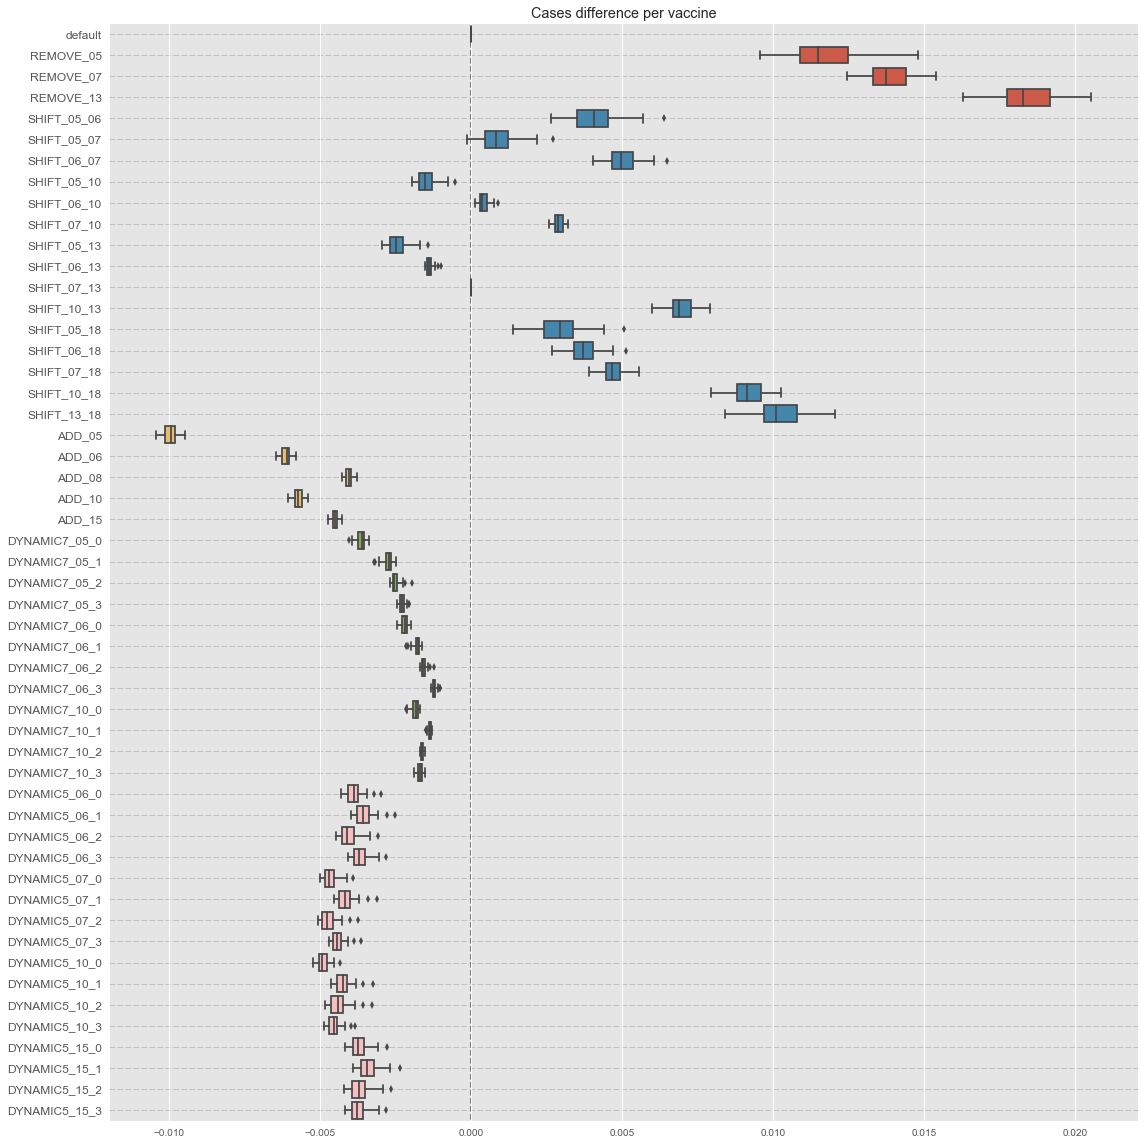

In [22]:
fig, axs = plt.subplots(1,figsize=(16,16))
ax=axs#[0]
sns.boxplot(data=df_ratio, ax=ax, orient="h",palette=colors)
ax.set_yticklabels(policy_names, fontdict=fontdict)#, rotation='vertical')
ax.set_title("Cases difference per vaccine")
ax.vlines([0, np.median(df_ratio['default'])],0,len(compare_policies),linestyles='--',alpha=0.3, zorder=-5)
lims = ax.get_xlim()
ax.hlines(np.arange(len(compare_policies)),*lims,linestyles='--',alpha=0.3, zorder=-5, lw=0.5)
ax.set_xlim(*lims)
# ax=axs[1]
# sns.boxplot(data=bp1y[0]/bp1y[2], ax=ax, orient="h")
# ax.set_yticklabels([])
# ax.set_title("Sick babies (0-1) difference over 10 years")
# ax.vlines(0,0,len(compare_policies),linestyles='--',alpha=0.3)
plt.tight_layout()
plt.show()

In [136]:
len(policies)

24

IndexError: list index out of range

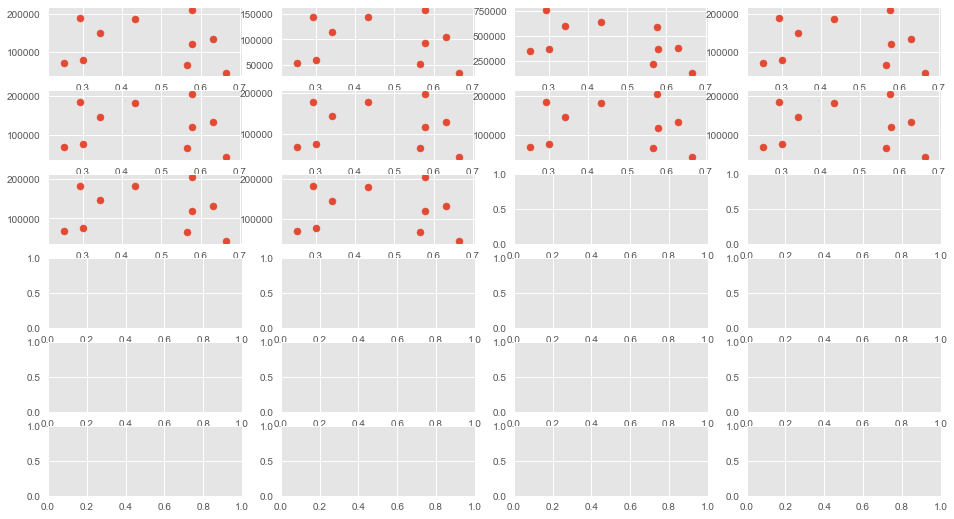

In [71]:
fig, axs = plt.subplots(6,4, figsize=(16,9))
axs = np.concatenate(axs)
cover = np.array(simulation['pregnant_coverage'])
sick_kids = np.array(policies[0]['sick'])[:,0]
for i in range(24):
    ax = axs[i]
    ax.scatter(cover, np.array(policies[i]['sick'])[:,0])

In [ ]:
gelman_rubin([mc])